In [114]:
# aideveloper
# Municipality Locator v1.0 - Find closest municipalities in the Philippines
import requests
import pandas as pd
import numpy as np
import folium

In [115]:
from OSMPythonTools.overpass import Overpass
ovp = Overpass()

In [116]:
import overpass
import geopandas as gpd

In [117]:
import os
import json
import collections

In [118]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from rasterio.plot import show
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [119]:
def search_municipalities(query):
    # Search OpenStreetMap for municipalities in the Philippines
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": f"{query}, Philippines",
        "format" : "json",
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        results = response.json()
        return results
    else:
        return None

In [120]:
def coastal_bld_cnt(municipality: dict, radius: int, shoredist: int):
    # Find number of local buildings near coast
    lat = municipality['lat']
    lon = municipality['lon']
    
    # formatted string using OSM overpass query language
    # - search for buildings within radius & store as '.a'
    # - search for coastline features within radius & store as '.b'
    # - search for buildings within '.a' that are within shoreline distance from features in '.b'
    # - return count (to conserve memory)
    qstring = f"way[\"building\"](around:{radius}, {lat}, {lon})->.a; way[\"natural\" = \"coastline\"](around:{radius}, {lat}, {lon})->.b; nwr.a(around.b:{shoredist}); (._;>;); out ids;"
    r = ovp.query(f"""
        {qstring}
    """)
    
    count = r.countWays()
    
    return count

In [121]:
api = overpass.API()

def coastal_json(municipality:dict):
    lat = municipality['lat']
    lon = municipality['lon']
    radius = municipality['radius']
    shoredist = municipality['shoredist']
    
    # formatted string using OSM overpass query language
    # - search for buildings within radius & store as '.a'
    # - search for coastline features within radius & store as '.b'
    # - search for buildings within '.a' that are within shoreline distance from features in '.b'
    # - return count (to conserve memory)
    qstring = f"way[\"building\"](around:{radius}, {lat}, {lon})->.a; way[\"natural\" = \"coastline\"](around:{radius}, {lat}, {lon})->.b; nwr.a(around.b:{shoredist}); (._;>;); out geom;"

    r = api.get(f"""
        {qstring}
    """)
    
    return r

def coast_json(municipality:dict):
    lat = municipality['lat']
    lon = municipality['lon']
    radius = municipality['radius'] * 1.5
    
    # formatted string using OSM overpass query language
    # - search for buildings within radius & store as '.a'
    # - search for coastline features within radius & store as '.b'
    # - search for buildings within '.a' that are within shoreline distance from features in '.b'
    # - return count (to conserve memory)
    qstring = f"way[\"natural\" = \"coastline\"](around:{radius}, {lat}, {lon}); (._;>;); out geom;"

    r = api.get(f"""
        {qstring}
    """)
    
    return r

In [122]:
def east_west(municipality: dict, df: gpd.GeoDataFrame):
    city_lat = float(municipality['lat'])
    city_lon = float(municipality['lon'])

    bld_lat = df['latitude'].median()
    bld_lon = df['longitude'].median()

    lat_dif = city_lat-bld_lat
    lon_dif = city_lon-bld_lon

    diff = (lat_dif, lon_dif)

    magnitude = np.sqrt(sum(x ** 2 for x in diff))
    norm_tuple = tuple(round(x / magnitude, 4) for x in diff)
    
    return norm_tuple

In [123]:
def margin_calc(direction: tuple, max=0.03):
    pad = [0.005 for i in range(4)]
    listicle = [0 for i in range (4)]
    if direction[0]>0:
        listicle[0] = max*abs(direction[0])
    else:
        listicle[1] = max*abs(direction[0])
    if direction[1]>0:
        listicle[2] = max*abs(direction[1])
    else:
        listicle[3] = max*abs(direction[1])

    result = [pad[i]+listicle[i] for i in range(4)]
    return result


In [124]:
def choose_municipality():
    print("Philippines Locality Risk Exposures")
    # will automatically add ', Philippines' to query
    # include region for added precision
    while True:
        municipality_name = input("Enter the name of target municipality in the Philippines: ")
        # many buildings do not have address metadata, so we use search radius from town center
        distance_from_city = int(input("Building search radius (meters): "))
        distance_from_coast = int(input("Maximum distance from the coast (in m): "))

        # Search for municipalities
        municipalities = search_municipalities(municipality_name)

        if municipalities:
            print("Top 3 closest results:")
            count_buildings=[]
            for idx, result in enumerate(municipalities[:3]):
                # find number of relevant buildings to print
                bldg_count = coastal_bld_cnt(result, distance_from_city, distance_from_coast)
                count_buildings.append(bldg_count)
                print(f"Result {idx + 1}:")
                print(f"Display Name: {result['display_name']}")
                print(f"Latitude: {result['lat']}, Longitude: {result['lon']}, Coastal Buildings: {bldg_count}")
                print("-------------------")
        
            print("Enter 0 and revise search if desired result is not shown.")
            print("-------------------")
        
            while True:
                selection = int(input("Matching result (1-3)): "))
                if 1 <= selection <= 3:
                    selected_municipality = municipalities[selection - 1]
                    selected_municipality["building_count"] = count_buildings[selection - 1]
                    selected_municipality["radius"] = distance_from_city
                    selected_municipality["shoredist"] = distance_from_coast
                    break
                elif selection == 0:
                    print("Please revise search")
                    # return to beginning of function
                    break
                else:
                    print("Invalid selection. Please choose a number between 1 and 3.")
            break
        else:
            print("No results found for the given query. Check spelling and try again")

    return selected_municipality

In [125]:
out_dir = ""
# save geojson.feature.FeatureCollection to file
def save_geojson(geoquery, city: dict):
    name = city['name']
    filename = f'{name}_osm_query.GeoJSON'
    folder_path = f'./{name}'
    
    # if local folder f'{name}' exists, save GeoJSON locally
    if not os.path.exists(folder_path):
        # prompt if user wants to create a local output folder or select an output path
        create_folder = input(f"Folder '{name}' does not exist in current directory. Do you want to create it? (yes/no): ")
        if create_folder.lower().startswith('y'):
            os.makedirs(folder_path)
            filepath = f'{folder_path}/{filename}'
        else:
            # open a selction screen for a filepath
            custom_path = input("Please enter the desired output path: ")
            folder_path = custom_path
            filepath = f'{folder_path}/{filename}'
    else:
        filepath = f'{folder_path}/{filename}'
        # check if f'{folder_path}/{filename}' exists and confirm overwrite
        while os.path.exists(filepath):
            overwrite = input(f"'{filepath}' already exists. Overwrite? (yes/no): ")
            if overwrite.lower().startswith('y'):
                # delete old file
                os.remove(filepath)
            else:
                new_filename = input(f"Please choose a new filename (default: {filepath}): ")
                new_filepath = f'{folder_path}/{new_filename.strip()}'
                if new_filename != filename:
                    filepath = new_filepath
                    break
                else:
                    filepath = new_filepath
                              
    with open(filepath, 'w') as file:
        json.dump(geoquery, file)
    
    print(f'OSM query output saved to {filepath}')
    return folder_path

In [126]:
# use 'choose_municipality' function to find desired city and output dict
city = choose_municipality()

Philippines Locality Risk Exposures


[overpass] downloading data: [timeout:25][out:json];
        way["building"](around:2000, 14.5906346, 120.9799964)->.a; way["natural" = "coastline"](around:2000, 14.5906346, 120.9799964)->.b; nwr.a(around.b:200); (._;>;); out ids;
    


Top 3 closest results:
Result 1:
Display Name: Manila, Metro Manila, Philippines
Latitude: 14.5906346, Longitude: 120.9799964, Coastal Buildings: 140
-------------------
Enter 0 and revise search if desired result is not shown.
-------------------


In [127]:
# use OSM api to download GeoJSON of relevant points of interest
query = coastal_json(city)
# convert GeoJSON to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(query['features'])
# export query output to local filepath
out_dir = save_geojson(query, city)

OSM query output saved to ./Manila/Manila_osm_query.GeoJSON


In [128]:
# convert geojson data types to osm id types
typemap = {
    'Point' : 'Node',
    'LineString' : 'Way',
}
gdf['type'] = gdf['geometry'].apply(lambda x: typemap.get(x.geom_type, None))

# create new DataFrame with house footprints only
blds = gdf[gdf['type'] == 'Way'].reset_index(drop=True).drop_duplicates()
blds = blds[~blds['geometry'].is_empty]

blds_count = len(blds)
if blds_count == city['building_count']:
    print(f"DataFrame 'blds' created with {blds_count} buildings")
else:
    print(f"DataFrame 'blds' created with {blds_count} buildings, {city['building_count']} buildings expected")

DataFrame 'blds' created with 140 buildings


In [129]:
# query OSM for nearby coastline data
coast = coast_json(city)
# convert to gdf
coast_gdf = gpd.GeoDataFrame.from_features(coast['features'])

coast_gdf['type'] = coast_gdf['geometry'].apply(lambda x: typemap.get(x.geom_type, None))

# create new DataFrame with house footprints only
coast_gdf = coast_gdf[coast_gdf['type'] == 'Way'].reset_index(drop=True).drop_duplicates()

In [130]:
# Define the URL for elevation data download
elevation_data_url = "https://data.humdata.org/dataset/d7f6e172-4433-4eb9-a96f-0524917eb11d/resource/2ca22e01-8ab7-4447-b565-653e93db55b0/download/phl_msk_alt.zip"

# Download and unzip the elevation data
elevation_zip_path = "elevation_data.zip"
elevation_data_dir = "PHL_msk_alt"
if not os.path.exists(elevation_data_dir):
    download = requests.get(elevation_data_url)
    with open(elevation_zip_path, "wb") as zip_file:
        zip_file.write(download.content)
    os.system(f"unzip {elevation_zip_path}")

# Load elevation data using rasterio
elevation_file_path = os.path.join(elevation_data_dir, "PHL_msk_alt.grd")
elevation_data = rasterio.open(elevation_file_path)

In [131]:
# Create a function to find the closest elevation match
def find_closest_elevation(point):
    row, col = elevation_data.index(point.x, point.y)
    return elevation_data.read(1, window=((row, row + 1), (col, col + 1)))[0][0]

In [132]:
# Add 'ele' column to 'blds' GeoDataFrame with elevation data
blds['ele'] = blds['geometry'].centroid.apply(find_closest_elevation)

In [133]:
# Add 'coordinates' column to blds GeoDataFrame according to centroid of buildings
blds['latitude'] = blds['geometry'].apply(lambda x: round(x.centroid.y, 4))
blds['longitude'] = blds['geometry'].apply(lambda x: round(x.centroid.x, 4))
# Create extent range for mapping
#grid_extent = (round(blds['latitude'].min()-0.1, 2), 
#               round(blds['latitude'].max()+0.1, 2),
#               round(blds['longitude'].min()-0.1, 2),
#               round(blds['longitude'].max()+0.1, 2))

In [134]:
def find_box(value, sorted_ranges):
    iterations = len(sorted_ranges)
    lower_bounds = []
    upper_bounds = []
    for rng in sorted_ranges:
        lower_bounds.append(rng[0])
        upper_bounds.append(rng[1])
    for i in range(iterations):
        if lower_bounds[i] <= value <= upper_bounds[i]:
            return i
        else:
            continue
    return None

In [135]:
def find_boxrange(datalist, max_bins=5):
    datalist = sorted(datalist)
    percents = [(i+1) * (100/max_bins) for i in range(max_bins-1)]
    pct_edges = np.percentile(datalist, percents)
    ranges = [[] for i in range(max_bins)]
    ranges[0].append(min(datalist))
    for i in range(len(pct_edges)):
        num = pct_edges[i]
        ranges[i].append(num+0.5)
        ranges[i+1].append(num+0.5)
    ranges[-1].append(max(datalist))
    
    return ranges

In [143]:
def make_binlabels(datalist, ranges: list):
    iterations = len(ranges)
    first_val = str(next((x for x in datalist if x > ranges[0][1]), None))
    new_range = [[0,0,0] for i in range(iterations)]
    for i in range(1,iterations):
        if np.ceil(ranges[i][0])==np.floor(ranges[i][1]):
            new_range[i]= [str(int(np.ceil(ranges[i][0])))]
        else:
            new_range[i][0] = str(int(next((x for x in datalist if x > ranges[i-1][1]), '-')))
            new_range[i][1] = '-'
            new_range[i][2] = str(int(np.floor(ranges[i][1])))
    first_label = ''.join(['<',str(first_val)])
    last_label = ''.join([new_range[-1][0],'+'])
    labels = [''.join(new_range[i]) for i in range(1,iterations-1)]
    for i in range(len(labels)):
        labels[i] = new_range[i][0] if new_range[i][0] == new_range[i][0] else skip
    labels.insert(0, first_label)
    labels.append(last_label)

    return labels

/var/folders/s8/txt2bgxx5v992lfctyncvn6r0000gn/T/ipykernel_98331/2436471310.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('GnBu_r', len(unique_elevation_levels))


TypeError: 'value' must be an instance of str or bytes, not a int

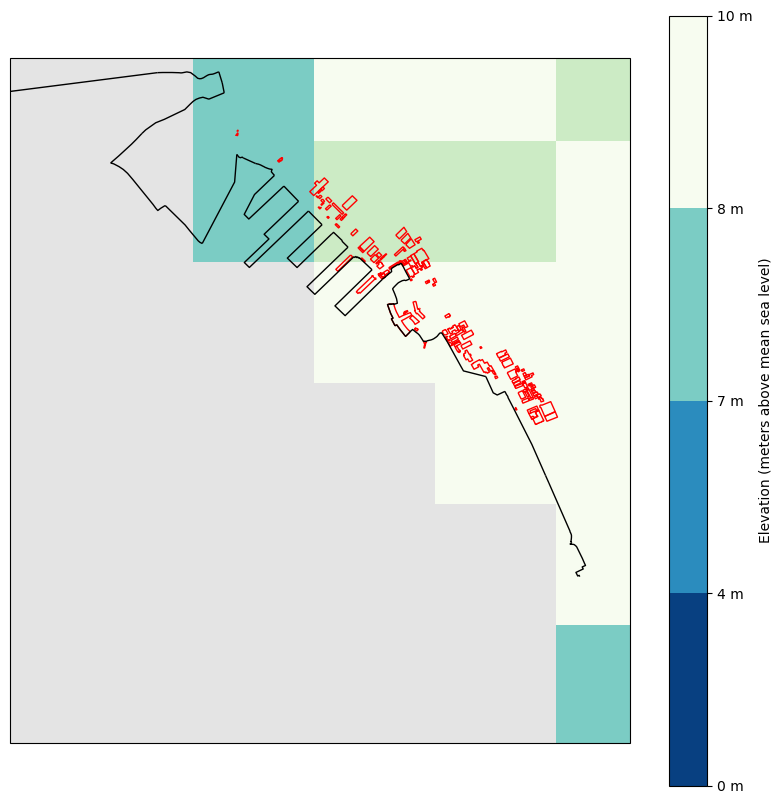

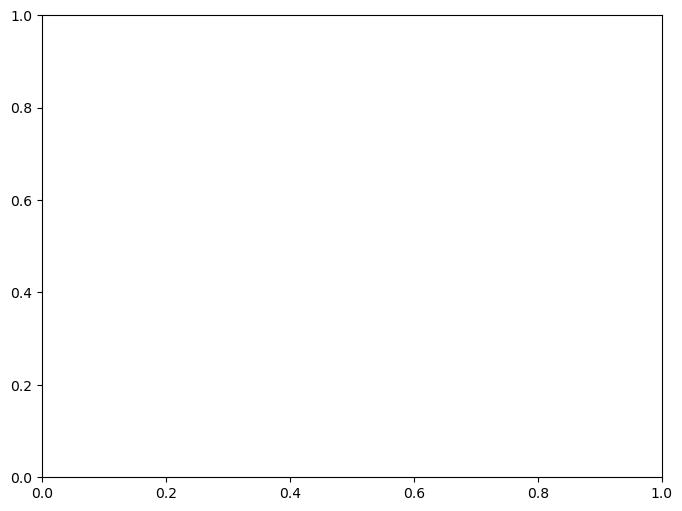

In [144]:
## Add shoreline map to subplots
# Create a figure and axis with Cartopy projection
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(10, 10))

#calculate bounds based on direction of coast
direc = east_west(city, blds)
pad = margin_calc(direc, max=0.02)
bounds= blds.total_bounds
ax.set_extent([bounds[0]-pad[2], bounds[2]+pad[3], bounds[1]-pad[0], bounds[3]+pad[1]])

# Read the data with a specified fill_value of 0 for ocean tiles
elevation_levels = elevation_data.read(1, window=elevation_data.window(*bounds), masked=True)

# Extract unique elevation levels
unique_elevation_levels = list(set(elevation_levels.filled(0).flatten().tolist()))

# Add contours from elevation data
color_map = plt.cm.get_cmap('GnBu_r', len(unique_elevation_levels))
color_map.set_bad(color='lightgray', alpha=.6)
show(elevation_data, ax=ax, cmap=color_map, alpha=1, vmin=min(unique_elevation_levels), vmax=max(unique_elevation_levels))

norm = mcolors.BoundaryNorm(boundaries=unique_elevation_levels, ncolors=color_map.N)

# Create a ScalarMappable object
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)

# Set up the colorbar with custom labels
cbar = plt.colorbar(sm, ax=ax, ticks=unique_elevation_levels, format='%1.0f m')
cbar.set_label('Elevation (meters above mean sea level)')

# Add outlines for houses from GeoDataFrame
blds.plot(ax=ax, edgecolor='red', linewidth=1)
# Add coastline ways from Geodataframe
coast_gdf.plot(ax=ax, edgecolor='black', linewidth=1)

# Save the map locally
map_image_path = f"{out_dir}/coastal_elevation_map.png"
plt.savefig(map_image_path, dpi=300, bbox_inches='tight')



## Add histogram to sublot
ele_data = sorted(blds['ele'].astype(int).tolist())
hist_data = []

# parameters for histogram
bin_limit = 5
ele_limit = 20
max_val = max(ele_data)
min_val = min(ele_data)

bin_boxes = find_boxrange(ele_data, bin_limit)
bin_labels = make_binlabels(ele_data, bin_boxes)
for x in ele_data:
    index = find_box(x, bin_boxes)
    hist_data.append(bin_labels[index])

bin_count = len(set(data))

# Calculate the bin width to ensure integer bins
bin_width = max(1, (max_val - min_val) // bin_count)
c = collections.Counter(hist_data)
lbl = [i[0] for i in c.items()]
hgt = [i[1] for i in c.items()]

# Generate a histogram of building elevations
plt.figure(figsize=(8, 6))
plt.bar(lbl, hgt, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Elevation (m)")
plt.ylabel("Number of Buildings")
plt.title("Building Elevations Histogram")

# Save the histogram locally
histogram_image_path = f"{out_dir}/elevation_histogram.png"
plt.savefig(histogram_image_path, dpi=300, bbox_inches='tight')

# Display the charts
plt.show()

In [ ]:
if len(ele_vals)<=bin_limit:
    vals = sorted(ele_vals)
    bin_labels = [f'<{vals[1]}' if x == -9999 else str(x) for x in vals]
    bin_boxes = [(x-0.5, x+0.5) for x in vals]
else:
    quintile = np.percentile(sorted(blds['ele'].tolist()), [20, 40, 60, 80])
    bin_num = len(set(quintile)) + 1
    bin_boxes = [() for i in range(bin_num)]
    for i in range(len(quintile)):
        if 
    #bin_dict = {x : (f'<{vals[1]}' if x == -9999 else str(x)) for x in vals}
    

bin_num

In [ ]:
#ele_data = blds['ele'].tolist()
ele_data = [bin_dict[x] for x in sorted(blds['ele'].tolist())]
plt.hist(ele_data)

plt.xticks(align='center')
ele_data

In [ ]:
ele_data = []
for elevation in blds['ele'].tolist():
    idx = find_box(elevation, bin_boxes)
    ele_data.append(bin_names[idx])

In [145]:
lbl

['<8', 0, '8', '13+']

In [146]:
bin_boxes

[[4, 7.5], [7.5, 8.5], [8.5, 10.5], [10.5, 10.5], [10.5, 13]]

In [149]:
np.percentile(ele_data,[20,40,60,80])

array([ 7.,  8., 10., 10.])